In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.optim as optim
from random import randint
import statistics
import torch.distributions as tdist

In [51]:
def prepro(x):
    return torch.from_numpy(x).float()

In [125]:
class Policy_Net(nn.Module):
    def __init__(self):
        super(Policy_Net, self).__init__()
        self.l1 = nn.Linear(24,128)
        self.l2 = nn.Linear(128,128)
        self.l3 = nn.Linear(128,2)

    def forward(self, state):
        state = F.relu(self.l1(state))
        state = F.relu(self.l2(state))
        state = F.tanh(self.l3(state))
        return state

#Uncomment to use trained network    
policy=Policy_Net()
policy.load_state_dict(torch.load('policy'))
policy.eval()
optimizer = optim.Adam(policy.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)

policy_1=policy
policy_1.load_state_dict(torch.load('policy_1'))
policy_1.eval()
optimizer_1 = optim.Adam(policy.parameters(), lr=0.0003)
scheduler_1 = optim.lr_scheduler.ExponentialLR(optimizer_1, 0.999)


In [53]:
class Critic_Net(nn.Module):
    def __init__(self):
        super(Critic_Net, self).__init__()
        self.l1 = nn.Linear(48,128)
        self.l2 = nn.Linear(128,128)
        self.l3 = nn.Linear(128,2)

    def forward(self, state):
        state = F.relu(self.l1(state))
        state = F.relu(self.l2(state))
        state = F.tanh(self.l3(state))
        return state
    

value_function=Critic_Net()
optimizer_critic = optim.Adam(value_function.parameters(), lr=0.01)
scheduler_critic = optim.lr_scheduler.ExponentialLR(optimizer_critic, 0.999)


In [54]:
def get_advantage(rewards, critic, states, l = .96):
  value_est = critic(states)
  value_est_0 = value_est[:-1]
  value_est_1 = value_est[1:]
  rewards = torch.tensor(rewards)
  advantage = rewards[:-1] + discount_rate * value_est_1 - value_est_0
  advantage = torch.cat((advantage,(rewards[-1]).view(1,2)))
  return advantage

In [55]:
def critic_loss(rewards, critic, states):
  value_est = critic(states)
  rewards = torch.tensor(rewards)
  return torch.mean((value_est-rewards)**2)

In [56]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount, epsilon, var, actor):

    rewards = rewards[:,actor].view(-1,1)
    # Calculate Probability of each action
    new_total_probs = policy(states)
    dist = tdist.multivariate_normal.MultivariateNormal(new_total_probs, torch.eye(2) * var)
    new_probs = dist.log_prob(actions)

    ratio = torch.exp(new_probs-old_probs)
    
    #Use clipped Loss function
    clipped_loss = torch.where(ratio > torch.tensor(1+epsilon), torch.tensor(1+epsilon), ratio)
    clipped_loss = torch.where(clipped_loss < torch.tensor(1-epsilon),  torch.tensor(1-epsilon), clipped_loss)
    clipped_loss = torch.min(ratio * rewards, clipped_loss * rewards)
    
    
    return torch.mean(clipped_loss)

In [57]:
def collect_trajectories(env, policy, policy_1, Max_Time, var, training_mode = True):
  env_info = env.reset(train_mode=training_mode)[brain_name]
  s0 = prepro(env_info.vector_observations)
  states = list()
  actions = list()
  rewards = list()
  old_probs = list()

  states_1 = list()
  actions_1 = list()
  rewards_1 = list()
  old_probs_1 = list()
    
  
  for step in range(Max_Time):
    if 1 == 0:
      action = 0
    else:
      #Gets Action
      probs = policy((s0[0]-states_mean)/states_std)
      probs = tdist.multivariate_normal.MultivariateNormal(probs, torch.eye(2) * var)
    
                                                           
      probs_1 = policy_1((s0[1]-states_mean)/states_std)
      probs_1 = tdist.multivariate_normal.MultivariateNormal(probs_1, torch.eye(2) * var)
    
      action = probs.sample()
      action_1 = probs_1.sample()
                                                           
      probs = probs.log_prob(action)
      probs_1 = probs_1.log_prob(action_1)
                                                           
      #Does Action
    env_info = env.step((torch.stack((torch.clamp(action,-1,1),torch.clamp(action_1,-1,1)),0).detach().numpy()))[brain_name]           # send all actions to tne environment
    state = env_info.vector_observations         # get next state (for each agent)
    reward = env_info.rewards                         # get reward (for each agent)
    done = env_info.local_done       
    #Adds to experience
    state = prepro(state)
    if step > -1:
      states.append(s0[0])
      actions.append(action)
      rewards.append(reward)
      old_probs.append(probs)
                                                           
      states_1.append(s0[1])
      actions_1.append(action_1)
      rewards_1.append(reward)
      old_probs_1.append(probs_1)   
    s0 = state
    if np.any(done):
      break
  scores = deepcopy(rewards)
  discount_scores = torch.tensor(deepcopy(rewards))
  
  #Calculates advantage, and discounted scores
  rewards = get_advantage(rewards, value_function,  torch.cat((torch.stack(states),torch.stack(states_1)),1))
  for i in reversed(range(len(rewards)-1)):
    rewards[i] += discount_rate *0.96* rewards[i + 1]
    discount_scores[i] += discount_rate  * discount_scores[i+1]

  rewards = deepcopy(discount_scores)
  return old_probs, old_probs_1, states, states_1, actions, actions_1, rewards, scores, discount_scores

In [58]:
import numpy as np

episode = 10000
discount_rate = .99
epsilon = .15
var = 2.0
tmax = 1000
SGD_epoch = 10
SGD_epoch_2 = 30
num_traj = 50
batch_size = 32
states_mean = 0
states_std = 1

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    train_var = var
    old_probs, old_probs_1, states, states_1, actions, actions_1, rewards, scores, discount_scores = list(),list(),list(), list(), list(), list(), torch.tensor(list()) ,list(), torch.tensor(list())
    for traj in range(num_traj):
      old_probs_, old_probs_1_, states_, states_1_, actions_, actions_1_, rewards_, scores_, discount_scores_ = collect_trajectories(env, policy, policy_1, tmax, var)
      
      old_probs = old_probs + old_probs_
      states = states + states_       
      actions = actions + actions_
        
      old_probs_1 = old_probs_1 + old_probs_1_
      states_1 = states_1 + states_1_
      actions_1 = actions_1 + actions_1_

      rewards = torch.cat((rewards,rewards_))
      discount_scores = torch.cat((discount_scores,discount_scores_))
      scores = scores + scores_
      mean_rewards.append(np.max(sum(np.array(scores_))))
    #old_probs, states, actions, rewards, scores = collect_trajectories(env, policy, tmax)
        
    #Normalize Rewards
    
    #Noramlize States and Means
    states_mean = (torch.mean(torch.stack(states),0) + 11 * states_mean)/12
    states_std = (torch.std(torch.stack(states),0) + 11 * states_std)/12
    states = (torch.stack(states)-states_mean)/states_std
    states_1 = (torch.stack(states_1)-states_mean)/states_std
    rewards_mean = 0
    rewards_std = 1
    rewards_mean = torch.tensor([torch.mean(rewards[:,0]),torch.mean(rewards[:,1])])
    rewards_std = torch.tensor([torch.std(rewards[:,0]),torch.std(rewards[:,1])])
    rewards = [(i-rewards_mean)/(rewards_std+0.0001) for i in rewards]

    total_rewards = np.sum(scores, axis=0)/num_traj
    
    actions = torch.stack(actions)
    old_probs = torch.tensor(old_probs)
    rewards = torch.stack(rewards)
    actions_1 = torch.stack(actions_1)
    old_probs_1 = torch.tensor(old_probs_1)

    
    # gradient ascent step
    for _ in range(SGD_epoch):
        
        permutation = torch.randperm(len(states))

        for i in range(0,len(states), batch_size):


            indices = permutation[i:i+batch_size]
            old_probs_batch, states_batch,actions_batch,rewards_batch = old_probs[indices], states[indices],actions[indices],rewards[indices]
            L = -clipped_surrogate(policy, old_probs_batch, states_batch, actions_batch, rewards_batch, discount_rate, epsilon, var, 0)

            optimizer.zero_grad()
            L.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(policy.parameters(), 3.0)
            optimizer.step()
            del L
        
    for _ in range(SGD_epoch):

        permutation = torch.randperm(len(states))

        for i in range(0,len(states), batch_size):


            indices = permutation[i:i+batch_size]
            old_probs_batch, states_batch,actions_batch,rewards_batch = old_probs_1[indices], states_1[indices],actions_1[indices],rewards[indices]

            L_1 = -clipped_surrogate(policy_1, old_probs_batch, states_batch, actions_batch, rewards_batch, discount_rate, epsilon, var, 1)

       

            optimizer_1.zero_grad()
            L_1.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(policy_1.parameters(), 3.0)
            optimizer_1.step()
            del L_1
    
    for _ in range(SGD_epoch_2):
        
        permutation = torch.randperm(len(discount_scores))
        
        for i in range(0,len(states), batch_size):
            indices = permutation[i:i+batch_size]
            states_1_batch, states_batch, scores_batch =  states_1[indices],states[indices],discount_scores[indices]
            # uncomment to utilize your own clipped function!
            L = critic_loss(scores_batch, value_function, torch.cat((states_batch,states_1_batch),1))

            optimizer_critic.zero_grad()
            L.backward()
            optimizer_critic.step()
            del L
    
    #Reduce epsilon
    if epsilon > 0.05:
        epsilon*=.999
    
    #Reduce Variance
    if var > 0.001:
        var*=0.9953
    
    
    if ((e+1)*num_traj)%50 ==0 :
        print("50 game average: {1:f}".format((e+1)*num_traj,np.mean(mean_rewards[-50:])))
        print(np.mean(mean_rewards))
        SGD_epoch_2 = 30
        if len(mean_rewards) > 200 and np.mean(mean_rewards[-100:]) >= 0.5:
            print('done')
            break
    #Anneal Learning Rates
    scheduler.step()
    scheduler_1.step()
    scheduler_critic.step()

C:\Users\Pranav\Anaconda4\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Pranav\Anaconda4\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


50 game average: 0.026600
0.026600000448524952
50 game average: 0.023400
0.025000000409781932
50 game average: 0.011400
0.020466667003929614
50 game average: 0.020800
0.020550000341609122
50 game average: 0.019400
0.02032000033557415
50 game average: 0.011400
0.018833333645015955
50 game average: 0.017200
0.01860000030802829
50 game average: 0.027000
0.019650000324472786
50 game average: 0.015200
0.019155555872453583
50 game average: 0.027000
0.01994000032916665
50 game average: 0.021200
0.020054545785215767
50 game average: 0.017400
0.019833333659917116
50 game average: 0.021000
0.01992307725147559
50 game average: 0.025000
0.020285714619926044
50 game average: 0.025600
0.0206400003383557
50 game average: 0.021000
0.020662500339094548
50 game average: 0.019000
0.020564706220346337
50 game average: 0.020800
0.02057777811669641
50 game average: 0.025000
0.020810526658437755
50 game average: 0.022800
0.020910000344738364
50 game average: 0.045000
0.022057143219170117
50 game average: 0.0

50 game average: 0.071800
0.047748315381827985
50 game average: 0.075800
0.04790502871048517
50 game average: 0.069600
0.04802555633501874
50 game average: 0.079800
0.04820110575455493
50 game average: 0.078200
0.04836593485058664
50 game average: 0.064200
0.04845245980235234
50 game average: 0.072400
0.04858260948352678
50 game average: 0.076000
0.04873081160095093
50 game average: 0.080200
0.048900000792677686
50 game average: 0.081800
0.0490759366242723
50 game average: 0.065000
0.04916063909438696
50 game average: 0.078400
0.049315344714140764
50 game average: 0.077600
0.04946421132746496
50 game average: 0.072200
0.04958324687643201
50 game average: 0.071200
0.049695834138353046
50 game average: 0.078000
0.04984248785388902
50 game average: 0.081800
0.05000721730464666
50 game average: 0.085600
0.05018974440239179
50 game average: 0.068000
0.050280613058949916
50 game average: 0.077600
0.050419290156344776
50 game average: 0.078000
0.050558586676953114
50 game average: 0.074400
0.

50 game average: 0.154800
0.07541011355032495
50 game average: 0.156200
0.07563641575997283
50 game average: 0.140200
0.0758167609733701
50 game average: 0.150600
0.07602507083777929
50 game average: 0.148600
0.07622666786952566
50 game average: 0.173000
0.07649473804887642
50 game average: 0.131800
0.07664751502103816
50 game average: 0.156800
0.07686832077134165
50 game average: 0.182600
0.07715879242529498
50 game average: 0.145000
0.07734465875343917
50 game average: 0.126600
0.0774792361938359
50 game average: 0.160800
0.07770626825445436
50 game average: 0.130600
0.07785000122658423
50 game average: 0.139400
0.07801680339697173
50 game average: 0.119600
0.07812919041997678
50 game average: 0.129600
0.07826792576121834
50 game average: 0.140800
0.07843602274093897
50 game average: 0.176200
0.07869812456386578
50 game average: 0.135600
0.07885026862127657
50 game average: 0.134000
0.0789973345771432
50 game average: 0.151200
0.07918936294870095
50 game average: 0.143200
0.079359152

50 game average: 0.318400
0.12407252527634118
50 game average: 0.258600
0.12432350937826142
50 game average: 0.483200
0.12499180825694257
50 game average: 0.398200
0.12549963018590357
50 game average: 0.490600
0.12617699637732613
50 game average: 0.340000
0.12657296491207348
50 game average: 0.389200
0.12705841230748433
50 game average: 0.472800
0.12769631192892295
50 game average: 0.608800
0.12858232242098117
done


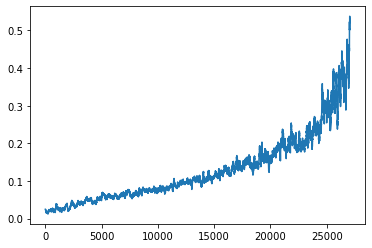

In [119]:
plt.plot([np.mean(mean_rewards[i:i+100]) for i in range(len(mean_rewards[:-100:]))])

In [120]:
#Average reward over 100 episodes > 0.5
np.mean(mean_rewards[27021:27121])

0.5128000077046454

In [123]:
#Save policy
torch.save(policy.state_dict(), 'policy')
torch.save(policy_1.state_dict(), 'policy_1')

In [126]:
#View Agents Play
for i in range(1):
    old_probs_, old_probs_1_, states_, states_1_, actions_, actions_1_, rewards_, scores_,a = collect_trajectories(env, policy, policy_1, 1000, 0.001, training_mode=False)

C:\Users\Pranav\Anaconda4\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
